In [1]:
# Import necessary libraries
include("harper.jl")
using LinearAlgebra, FFTW, .harper, Plots, Statistics, LaTeXStrings, Measures

# Summary

Here we compute the charge density in a Landau level subject to a potential 
$$
    U(x,y) = U_1 \cos(2\pi x/a) + U_2 \cos(2\pi y/b)
$$
We'll assume $U_1,U_2 \ll \hbar \omega_c$ and also $U_2 \ll U_1$, modeling the incipient charge density wave along $y$. Let the flux per unit cell be
$$
    \phi = abB/2\pi = \frac{p}{q} = A_0 \frac{1}{2\pi \ell^2}
$$
where $A_0 = ab$ is the unit cell area and $\ell = 1/\sqrt{B}$. Let $r = 1,\ldots, p$ be the subband index. Then $\nu = r/p$ is the filling. 

We will talk about two momentum quantum numbers $k_1 \in [0,2\pi/aq)$ and $k_2 \in [0,2\pi/b)$. The Bloch functions will be $u_{k_1k_2}$. They take the form
$$
    u_{k_1k_2} = \sum_{n=1}^p d_n \sum_{l\in \mathbb{Z}} \chi\left(x- \frac{\hbar k_2}{eB} - lqa - \frac{nqa}{p}\right) \exp\left[ -ik_1(x-lqa -nqa/p)+2\pi i y (lp +n)/b\right]
$$
with
$$
    \chi(x) = e^{-Bx^2/2}.
$$
The amplitudes $d_n$ satisfy the eigenequation 
$$
    U_2 e^{-iqak_1/p} d_{n-1}+ 2U_1 \cos(qbk_2/p+2\pi nq/p)d_n + U_2 e^{iqak_1/p}d_{n+1} = E d_n
$$
where $d_{n+p} = d_n$ (i.e. periodic conditions in $n$). This is a $p\times p$ matrix equation known as Harper's equation. 

Our plan is as follows. Define the microscopic parameters $a,b,q,p,U_1,U_2$
and hyperparameters $Nk_1,Nk_2,M_x,M_y,N_x,N_y$. 

Initialize a set of $x$ and $y$ points. We'll take a region of $M_x$ periods (of length $a$) in the $x$ direction and $M_y$ periods (of length $b$) in the $y$ direction. The grid will have $N_x\times N_y$ points. 

Initalize a mesh of $(k_1,k_2)$ of size $Nk_1,Nk_2$. For each $(k_1,k_2)$, solve Harper's equation to obtain a $d$-vector $\vec d_w(k_1,k_2)$ where $w=1,...,p$. Compute $|u_{k_1,k_2,w}(x,y)|^2$ in the aforementioned real-space region.

Finally, sum over all $k_1,k_2$ and $w=1,...,r$ where the filling is $r/p$ to obtain the charge density

$$
    \rho(x,y) = \sum_{k_1,k_2}\sum_{w=1}^r |u_{k_1,k_2,w}(x,y)|^2.
$$

# Below

Below, we are choosing $\Phi = p/q = 3/2$ and filling $\nu = 1/3$ corresponding to a region with $C=1$. Fixing $a_0/\ell$ then gives us the period in the $y$ direction as 

$$a_y/a_0 = \frac{2\pi \ell^2}{|1-\nu|a_0^2} = \frac{3}{2}\frac{2\pi \ell^2}{a_0^2}.$$

We set $U_1 = 1.0, U_2 = 0.05$. 

In [2]:
# Test parameters (same as before)
C = 1 # Chern number we're interested in 
a = 2.5   # Periodicity in x-direction
lB = 1.0 # magnetic length 
q = 2    # Flux is p/q
p = 3    # There are p subbands 
U1 = 1.0  # Amplitude of cosine potential in x-direction
U2 = 0.0 # Amplitude of cosine potential in y-direction
Mx = 6  # Number of periods in x-direction
My = 4
ν = Float64(1/3) # filling 

# Derived quantity 
b = 2π*lB^2/(a*abs(C-ν))  # Periodicity in y-direction

# Define k-space and real-space grids (same as before)
Nk2 = 12  # Number of points in k2 mesh
Nk1 = round(Int, Nk2/q) # Number of points in k1 mesh
Nx = 240  # Number of grid points in x-direction, preferably a multiple of Mx
Ny = 240  # Number of grid points in y-direction
k1 = range(0, stop=2π/(q*a), length=Nk1)
k2 = range(0, stop=2π/b, length=Nk2)
x = range(0, stop=Mx*a, length=Nx)
y = range(0, stop=My*b, length=Ny)

# Solve Harper's equation to get eigenvectors
@time eigenvalues, eigenvectors = solve_harpers_equation(U1, U2, a, b, q, p, k1, k2)

# Compute Bloch functions
@time bloch_functions = compute_bloch_functions(eigenvectors, x, y, k1, k2, a, b, q, p, Mx)

r = 1     # Number of occupied subbands (example value)
# Calculate charge density
@time charge_density = calculate_charge_density(bloch_functions, k1, k2, r, p);

  0.766444 seconds (3.77 M allocations: 192.020 MiB, 5.88% gc time, 99.85% compilation time)
 21.873570 seconds (280.81 k allocations: 203.418 MiB, 0.20% gc time, 0.53% compilation time)
  0.057856 seconds (44.38 k allocations: 3.065 MiB, 63.72% compilation time)


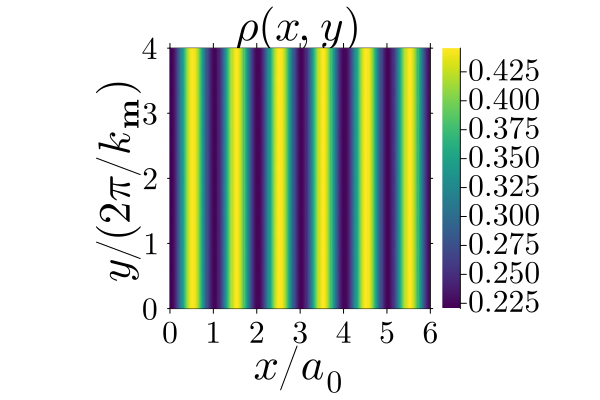

In [ ]:
charge_density_full_filling = calculate_partial_charge_density(bloch_functions,eigenvalues,1.0)
factor = 1/mean(charge_density_full_filling) # get a normalization factor

# Plotting the charge density with customizations
partial_charge_density = calculate_partial_charge_density(bloch_functions,eigenvalues,ν)
partial_charge_density = charge_average(partial_charge_density,q,Mx)
partial_charge_density = circshift(partial_charge_density,[0,30])
partial_charge_density = factor .* partial_charge_density
fs1 = 20
fs2 = 30  # Larger font size for labels

# Set the color limits for the colorbar
#clims = (minold, maxold)  # Example: setting lower bound to 0 and upper bound to the maximum value

p1=heatmap(x/a, y/b, 
    partial_charge_density', 
    c=:viridis, 
    xlim = [minimum(x/a), maximum(x/a)],
    ylim = [minimum(y/b), maximum(y/b)],
    colorbar=true,
    fontfamily="Computer Modern",  
    #clim=clims,  
    framestyle=:box,
    xlabel=L"x/a_0", 
    ylabel=L"y/(2\pi/k_{\mathbf{m}})", 
    xticks=0:Mx,
    yticks=0:My,
    tick_direction=:out,
    title=L"\rho(x,y)",
    titlefontsize=fs2,
    aspect_ratio=:1.5,
    guidefont=font(fs2, "Computer Modern"),
    tickfont=font(fs1, "Computer Modern"),
    bottom_margin=4.5mm,
)
display(p1)

In [7]:
# Test parameters (same as before)
C = 1 # Chern number we're interested in 
a = 2.5   # Periodicity in x-direction
lB = 1.0 # magnetic length 
q = 2    # Flux is p/q
p = 3    # There are p subbands 
U1 = 1.0  # Amplitude of cosine potential in x-direction
U2 = 0.2 # Amplitude of cosine potential in y-direction
Mx = 6  # Number of periods in x-direction
My = 4
ν = Float64(1/3) # filling 

# Derived quantity 
b = 2π*lB^2/(a*abs(C-ν))  # Periodicity in y-direction

# Define k-space and real-space grids (same as before)
Nk2 = 12  # Number of points in k2 mesh
Nk1 = round(Int, Nk2/q) # Number of points in k1 mesh
Nx = 240  # Number of grid points in x-direction, preferably a multiple of Mx
Ny = 240  # Number of grid points in y-direction
k1 = range(0, stop=2π/(q*a), length=Nk1)
k2 = range(0, stop=2π/b, length=Nk2)
x = range(0, stop=Mx*a, length=Nx)
y = range(0, stop=My*b, length=Ny)

# Solve Harper's equation to get eigenvectors
@time eigenvalues, eigenvectors = solve_harpers_equation(U1, U2, a, b, q, p, k1, k2)

# Compute Bloch functions
@time bloch_functions = compute_bloch_functions(eigenvectors, x, y, k1, k2, a, b, q, p, Mx)

r = 1     # Number of occupied subbands (example value)
# Calculate charge density
@time charge_density = calculate_charge_density(bloch_functions, k1, k2, r, p);

  0.143295 seconds (28.52 k allocations: 1.369 MiB, 97.44% compilation time)
 21.826052 seconds (8 allocations: 189.844 MiB, 0.03% gc time)
  0.017763 seconds (6 allocations: 900.156 KiB)


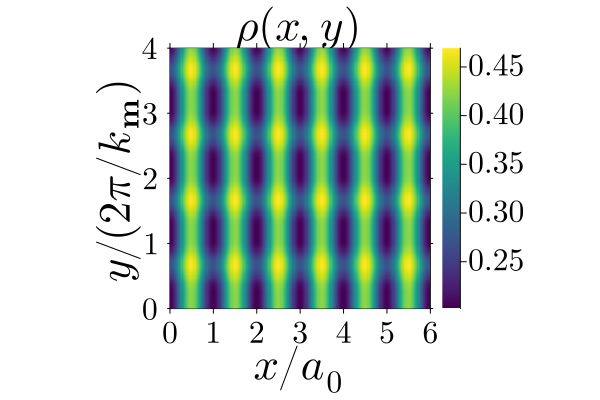

In [8]:
charge_density_full_filling = calculate_partial_charge_density(bloch_functions,eigenvalues,1.0)
factor = 1/mean(charge_density_full_filling) # get a normalization factor

# Plotting the charge density with customizations
partial_charge_density = calculate_partial_charge_density(bloch_functions,eigenvalues,ν)
partial_charge_density = charge_average(partial_charge_density,q,Mx)
partial_charge_density = circshift(partial_charge_density,[0,30])
partial_charge_density = factor .* partial_charge_density
fs1 = 20
fs2 = 30  # Larger font size for labels

# Set the color limits for the colorbar
#clims = (minold, maxold)  # Example: setting lower bound to 0 and upper bound to the maximum value

p1=heatmap(x/a, y/b, 
    partial_charge_density', 
    c=:viridis, 
    xlim = [minimum(x/a), maximum(x/a)],
    ylim = [minimum(y/b), maximum(y/b)],
    colorbar=true,
    fontfamily="Computer Modern",  
    #clim=clims,  
    framestyle=:box,
    xlabel=L"x/a_0", 
    ylabel=L"y/(2\pi/k_{\mathbf{m}})", 
    xticks=0:Mx,
    yticks=0:My,
    tick_direction=:out,
    title=L"\rho(x,y)",
    titlefontsize=fs2,
    aspect_ratio=:1.5,
    guidefont=font(fs2, "Computer Modern"),
    tickfont=font(fs1, "Computer Modern"),
    bottom_margin=4.5mm,
)
display(p1)